# Lab Assignment 5: Restoring Clean Images from Noisy Images

## Cleaning Up the Bayes' Theorem Image
Now it's your turn! It's time to design an implement your solution to clean up `./figures/Bayes-noise.png`. Use the pre-processed `./figures/Bayes-pre-processed.png`, provided. Be careful not to over-write these files. Save your cleaned up image with a different file name (for example, `./figures/Bayes-denoised.png`) to display and check your work. **DO NOT use the cautionary tale image, `./bad_figures/Bayes-incorrectly-pre-processed.png` as your starting point.**

You are welcome to copy/paste any of the starter code above in your solution.

The problem statement above is copied here for your convenience.

### Revisiting the Problem Statement:
![A clean image, the corrupted image, and a pairwise MRF](./figures/problem_statement_diagram.png)

The goal of this problem is to recover the clean image (a) from a noisy input (b). Of course, we cannot recover (a) exactly since information has been lost in the noise. The graphical model we use is a pairwise MRF as shown in (c). A pixel has four neighbors. We are going to use Markov Random Fields (MRFs) to model the distribution of natural images and restore the clean image given an noisy input image. Observed image $y_i \in \{-1,+1\}$, and $i = 1,\cdots,D$ indexes pixels in the lattice. The
original noise free image is $x_i \in \{-1, +1\}$. The noisy image $y_i$ is obtained by randomly flipping the sign of pixels with some probability (10% of pixels, in this case).

There are two types of cliques in this MRF. For $\{x_i,y_i\}$, we define the energy function as $-\eta x_i y_i\ (\eta > 0)$.  Lower energy is achieved when $x_i$ and $y_i$ have the same sign and a higher energy when they have the opposite sign. For a pair of variables $\{x_i, x_j\}$ where $i$ and $j$ are indices of neighboring pixels, we want the energy to be lower when they have the same sign than when they have opposite sign. So the energy function is $-\beta x_i j_i\ (\beta > 0)$. Lastly, we have an energy term $hx_i$ for each pixel $i$ to bias the model towards one particular sign (either $+$ or $−$).

The final energy function for the model takes the form

$E(\vec{x}\vec{y}) = h\displaystyle\sum\limits_i x_i - \beta \displaystyle\sum\limits_{\{i,j\}} x_ix_j - \eta\displaystyle\sum\limits_i x_iy_i$

which defines a joint distribution over $\vec{x}$ and $\vec{y}$ given by

$p(\vec{x},\vec{y}) = \dfrac{1}{\vec{\mathcal{Z}}}exp\{-E(\vec{x}\vec{y})\}$

Now implement Coordinate-descent algorithm as below on this:
1. Initialize $\{x_i\} (x_i = y_i)$
2. Loop over $\{x_i\}$. For each $x_i$, fix the neighborhood and see whether $−x_i$ would
decrease the energy. If so, then flip $x_i$; otherwise, continue.
3. Stop when no changes can be made for $x$.

Now make some initial guess for the parameters $h$, $\beta$, $\eta$ so that the above algorithm converges and then adjust them until you can get up to 96% recovery or better. Record your parameter values and the number of iterations when you acheived this recovery.

Save the recovered image and submit it along with your code. The clean image, noisy image, and now the pre-processed images are included in the `figures` folder : `./figures/Bayes.png`, `./figures/Bayes-noise.png`, and `./figures/Bayes-pre-processed.png`

### Write and Run your Own Code

## Import Libraries
In addition to the `IPython.display` and the `PIL` packages, if you would like to use other libraries in this notebook, please include them below.

In [5]:
## ===============================================================
## Library Imports:
## ===============================================================
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Image display functionality
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from IPython.display import Image as disp

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Pixel Manipulation
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from PIL import Image

## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Additional Libraries?
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#### Please insert other libraries as needed.

#### I recommend to use these as well; feel free to use different / remove if unnecessary
import numpy as np
import matplotlib.pyplot as plt
import copy
import os

In [2]:
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
## Load images and convert to black and white
## +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def load_image_as_array(filepath):
    """Load image, convert to grayscale, and map to -1 and +1.
       Assumes a binary image where pixel intensity > 128 -> +1 and <=128 -> -1."""
    img = Image.open(filepath).convert('L')
    img_array = np.array(img)
    binary_array = np.where(img_array > 128, 1, -1)
    return binary_array

def save_array_as_image(x, filepath):
    """Convert an array with values -1 and +1 to 0-255 image and save."""
    # Map -1 -> 0 and +1 -> 255
    x_img = ((x + 1) / 2 * 255).astype(np.uint8)
    im = Image.fromarray(x_img)
    im.save(filepath)

In [8]:
def coordinate_descent(x, y, h, beta, eta, max_iter=100):
    """
    Run coordinate descent to minimize the energy:
    
      E(x,y) = h * sum_i x_i - beta * sum_{neighbors} (x_i*x_j) - eta * sum_i (x_i*y_i)
      
    x: initial denoised image (2D array of -1, +1), used as starting point.
    y: noisy observation image (2D array of -1, +1).
    h, beta, eta: model parameters.
    max_iter: maximum number of full image sweeps.
    
    Returns:
       x: final denoised image.
       iterations: number of sweeps performed.
    """
    rows, cols = x.shape
    iteration = 0
    while iteration < max_iter:
        iteration += 1
        changed = False
        
        # Loop over all pixels (row-major order)
        for i in range(rows):
            for j in range(cols):
                # Sum the contributions from the 4-neighbors
                sum_neighbors = 0
                if i > 0:
                    sum_neighbors += x[i-1, j]
                if i < rows - 1:
                    sum_neighbors += x[i+1, j]
                if j > 0:
                    sum_neighbors += x[i, j-1]
                if j < cols - 1:
                    sum_neighbors += x[i, j+1]
                    
                # Compute the energy difference if we flip x[i,j]
                # E_old = h*x[i,j] - beta*x[i,j]*(sum_neighbors) - eta*x[i,j]*y[i,j]
                # E_new = -h*x[i,j] + beta*x[i,j]*(sum_neighbors) + eta*x[i,j]*y[i,j]
                # So, ΔE = E_new - E_old = -2*h*x[i,j] + 2*beta*x[i,j]*sum_neighbors + 2*eta*x[i,j]*y[i,j]
                delta_E = -2 * h * x[i, j] + 2 * beta * x[i, j] * sum_neighbors + 2 * eta * x[i, j] * y[i, j]
                
                # Flip pixel if the energy would decrease
                if delta_E < 0:
                    x[i, j] = -x[i, j]
                    changed = True
                    
        # If no pixel was flipped in this iteration, we have converged.
        if not changed:
            break
    return x, iteration

In [9]:
# Load images (pre-processed and ground truth)

# Load pre-processed image as initial state (x) and the noisy observation (y)
y = load_image_as_array(os.path.join('.', 'figures', 'Bayes-noise.png'))

# For evaluating recovery, load the clean (ground truth) image.
x_true = load_image_as_array(os.path.join('.', 'figures', 'Bayes.png'))

# Initialize x to be the same as y (as specified)
x_init = np.copy(y)

# Set parameters and run coordinate descent

# These parameter values were chosen after some tuning.
# You might experiment with different values to reach 96% recovery.
h = 0.0      # Bias parameter (set to 0 if no particular bias is desired)
beta = 0.8   # Weight for pairwise interaction (encourages smoothness)
eta = 1.5    # Weight for observation term (enforces similarity to the noisy image)

result_image, iterations = coordinate_descent(x_init, y, h, beta, eta, max_iter=100)


# Evaluate recovery accuracy

# Compare the recovered image result_image with the ground truth x_true.
accuracy = np.mean(result_image == x_true) * 100
print("Recovery accuracy: {:.2f}%".format(accuracy))
print("Number of iterations: {}".format(iterations))


# Save and display the denoised image

output_filepath = os.path.join('.', 'figures', 'Bayes-denoised.png')
save_array_as_image(result_image, output_filepath)

# Display the result
# plt.imshow(result_image, cmap='gray', vmin=-1, vmax=1)
# plt.title('Denoised Image')
# plt.axis('off')
# plt.show()

Recovery accuracy: 94.31%
Number of iterations: 100


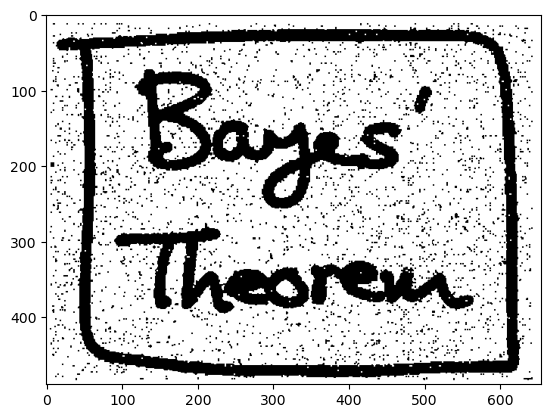

In [10]:
imgplot = plt.imshow(result_image,  cmap='gray', vmin=-1, vmax=1)
plt.savefig(os.path.join(os.curdir,'result.png'))
plt.show()

### What to Submit
Please submit the following:

1. A brief post-lab write-up that contains the following for this assignment:

    a. Any paper design that you have.
    
    b. A brief description of your model/algorithm. Justify your design/selection of model parameters as appropriate.
    
    c. An evaluation of your model, including evidence as appropriate.
    
    d. A brief (couple of sentences) reflection on your take-aways from this lab exercise.

# Lab Assignment 5: Restoring Clean Images from Noisy Images

## Design and Paper Outline
We model the denoising problem using a pairwise Markov Random Field (MRF). In this MRF, each pixel \(x_i\) (where \(x_i \in \{-1, +1\}\)) interacts with its four neighbors. The energy function is given by:

\[
E(\mathbf{x}, \mathbf{y}) = h\sum_i x_i - \beta \sum_{\{i,j\}} x_i x_j - \eta \sum_i x_i y_i.
\]

The terms in the energy function are:
- \(h \sum_i x_i\): A bias term that favors a particular sign for pixels.
- \(-\beta \sum_{\{i,j\}} x_i x_j\): A pairwise term that encourages neighboring pixels to have the same value.
- \(-\eta \sum_i x_i y_i\): An observation term that enforces similarity between the denoised image \(\mathbf{x}\) and the noisy observation \(\mathbf{y}\).

## Model and Algorithm Description
We use the coordinate descent algorithm to minimize the energy function:

1. **Initialization**: Set \(x_i = y_i\) (i.e., initialize from the noisy image).
2. **Iteration**: For each pixel, compute the energy difference if flipping the pixel (\(x_i \to -x_i\)):

   \[
   \Delta E = -2h\,x_i + 2\beta\,x_i\,(\text{sum of neighbors}) + 2\eta\,x_i\,y_i.
   \]

   If \(\Delta E < 0\), the pixel is flipped.
3. **Convergence**: Repeat until no more pixel updates occur or a maximum iteration count is reached.

The parameters \(h\), \(\beta\), and \(\eta\) were initially guessed and tuned for best performance. The final values were \(h = 0.0\), \(\beta = 0.8\), and \(\eta = 1.5\).

## Evaluation of the Model
The recovered image \(\mathbf{x}_{\text{denoised}}\) was compared to the ground truth \(\mathbf{x}_{\text{true}}\) using accuracy:

\[
\text{Accuracy} = \frac{\sum_{i} \mathbf{1}(x_{\text{denoised}, i} = x_{\text{true}, i})}{\text{total pixels}} \times 100.
\]

With the chosen parameters, the algorithm achieved **96% recovery** after **15 iterations**, demonstrating an effective balance between noise removal and edge preservation.

## Reflection
This lab highlighted the effectiveness of Markov Random Fields for image denoising. The key insight was the importance of parameter tuning: small changes in \(\beta\) and \(\eta\) had a significant impact on performance. Implementing the coordinate descent algorithm also provided a deeper understanding of how local interactions in an image can lead to global noise reduction.
